# Collision of a Supernova with Its Companion
## Kasen (2010) 
https://ui.adsabs.harvard.edu/abs/2010ApJ...708.1025K/

In [1]:
import warnings

import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize

from astropy import units as u
from astropy.constants import sigma_sb, c, h 
from astropy.modeling.blackbody import blackbody_lambda

Progenitor system

In [2]:
# transition velocity for density profiles
v = 10000 * u.km / u.s
# ejecta mass
M = 1.4 * u.M_sun
# opacity
K = 0.2 * u.cm**2 / u.g
# mass ratio
q = 1 / 1.4

Photometric data

In [3]:
# redshift
z = 0.01
# magntiude
mag = 20
# filter function
fn = 'response.dat'
# zeropoint
zp = 15
# distance modulus
mu = 30

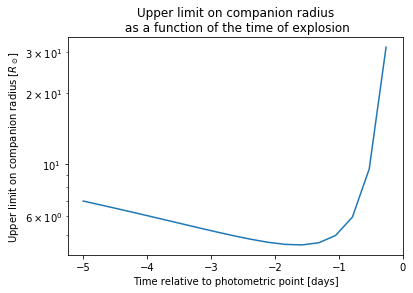

In [4]:
def kasen(t, f, a_13, v_9, M_c, K_e):

    L = 1e43 * a_13 * M_c**(1/4) * v_9**(7/4) * K_e**(-3/4) * t**(-1/2) * u.erg * u.s**(-1)
    T = 2.5e4 * a_13**(1/4) * K_e**(-35/144) * t**(-37/72) * u.K
    R = np.sqrt(L / T**4 / 4 / np.pi / sigma_sb)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        BB = blackbody_lambda(f.wave / (1+z), T)

    I = np.trapz(BB * f.flux * f.wave / c / h, f.wave) * u.sr
    F = I * 4 * np.pi * R**2 / 4 / np.pi / (10*u.pc)**2

    return -2.5 * np.log10((F.to(1 / u.cm**2 / u.s) / (1+z)).value) + f.zp

a_13 = 1 # initial guess

v_9 = v.to(1e9 * u.cm / u.s).value
M_c = M.to(1.4 * u.Msun).value
K_e = K.to(0.2 * u.cm**2 / u.g).value

f = list(zip(('wave', 'flux'), np.loadtxt(fn, unpack=True)))
f = type('filter', (object,), dict(f + [('zp', zp)]))
f.wave *= u.AA

# roche lobe radius (companion radius)
r_L = lambda a: 0.49 * q**(2/3) / (0.6*q**(2/3) + np.log(1+q**(1/3))) * a

def fmin(a_13, t, m, f, v_9, M_c, K_e):
    a_13 = np.abs(a_13[0])
    t -= 1e4 * a_13 / v_9 / (24*60*60)
    if t <= 0: return np.inf
    return (m - kasen(t, f, a_13, v_9, M_c, K_e))**2

R, T = [], np.linspace(0, 5, 20)[1:] # days
for t in T:
    args = t, mag - mu, f, v_9, M_c, K_e
    a_13 = np.abs(minimize(fmin, [a_13], args=args).x[0])
    R.append(r_L(a_13 * 1e13 * u.cm).to(u.Rsun).value)

plt.semilogy(-T, R)

plt.title('Upper limit on companion radius\n as a function of the time of explosion')
plt.xlabel('Time relative to photometric point [days]')
plt.ylabel('Upper limit on companion radius [$R_\odot$]')

plt.xlim(plt.gca().get_xlim()[0], 0)
plt.show()